In [1]:
import pandas as pd 
import numpy as np
import re
import chess.pgn
import chess
from plotnine import *


In [2]:
def char_range(c1, c2):
    """Generates the characters from `c1` to `c2`, inclusive."""
    for c in range(ord(c1), ord(c2)):
        yield chr(c)

In [3]:
def create_steps(inp_list):
    """Creates path pairs (from to) """
    return(list(zip(inp_list, inp_list[1:])))

In [4]:
def initialize():
    #Initialize the chess board configuration
    board_template = {'d8':'Black Queen',
           'd1':'White Queen',
           'e8':'Black King',
           'e1':'White King',
           'c1':'c1 Bishop',
           'c8':'c8 Bishop',
           'f1':'f1 Bishop',
           'f8':'f8 Bishop',
           'b1':'b1 Knight',
           'b8':'b8 Knight',
           'g1':'g1 Knight',
           'g8':'g8 Knight',
           'a1':'a1 Rook',
           'a8':'a8 Rook',
           'h1':'h1 Rook',
           'h8':'h8 Rook'}
    for col in char_range('a','i'):
            for row in range(2,8):
                if row in [2,7]:
                    board_template[col + str(row)] =  col + str(row)+' Pawn'
                else:
                    board_template[col + str(row)] = ''
    # Initialize the path each piece takes 
    paths_template = {value: [key] for key, value in board_template.items() if value != ''}
    return(board_template, paths_template)   

In [5]:
# Initialize the x,y coordinates of the board
names, x, y = [], [], []
for square in chess.SQUARES:
    names.append(chess.square_name(square))
    x.append(chess.square_file(square) + 1)
    y.append(chess.square_rank(square) + 1)
dfboard = pd.DataFrame({'square_name':names, 'x':x, 'y':y})
dfboard['color'] = np.where((dfboard.x+dfboard.y)%2==0, 'b', 'w')
dfboard_dict = dfboard.drop(columns = 'color').set_index('square_name').T.to_dict('list')

In [6]:
def update_positions(square_from, square_to, castling, white):
    """Updates the position and paths for each piece"""
    if castling == 'kingside':
        if white == True:
            square_from = ['e1', 'h1']
            square_to = ['g1', 'f1']
        else:
            square_from = ['e8', 'h8']
            square_to = ['g8', 'f8']
    elif castling == 'queenside':
        if white == True:
            square_from = ['e1', 'a1']
            square_to = ['c1', 'd1']
        else:
            square_from = ['e8', 'a8']
            square_to = ['c8', 'd8']
    for sq_from, sq_to in zip(square_from, square_to):
        board_pos[sq_to] = board_pos[sq_from]
        board_pos[sq_from] = ''
        paths[board_pos[sq_to]].append(sq_to)

In [9]:
def save_condensed_plot(df, file_name):
    (ggplot(data = dfboard, mapping = aes(x = 'x', y = 'y')) 
     + geom_tile() 
     + scale_fill_manual(guide = False, values =  ("black", "white"))
     + theme_void() 
     + geom_segment(data = df,#xo.loc[xo.Piece == 'White Queen'], 
                    mapping = aes(x = 'x_from', xend = 'x_to', y = 'y_from', yend = 'y_to'), 
                    color = 'green', 
                    size = 2 ,
                    #position = position_jitter(width = 0.3, height = 0.3),
                    lineend = 'round',
                    arrow = arrow(length=0.2, type = 'closed'),
                    inherit_aes= False)
    + facet_wrap('Piece')
    + theme(strip_background = element_blank(), 
            strip_text = element_blank(),
            panel_spacing = -0.2)
    ).save('../Chess player data/' + file_name)

In [7]:
# Games taken from http://www.pgnmentor.com/files.html
f = open("../Master games/Carlsen.pgn")
counter = 0

C:\Users\George\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\George\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/George/Desktop/Chess player data/Carlsen_white/2.jpg
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\George\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\George\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/George/Desktop/Chess player data/Other_black/2.jpg
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\George\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\George\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: Plotn

KeyboardInterrupt: 

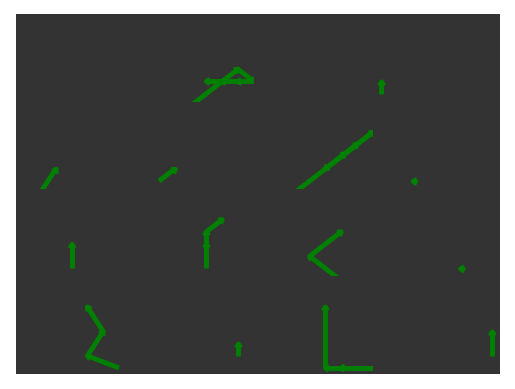

In [10]:
# Updates positions and saves the generated plot
while True:
    game = chess.pgn.read_game(f)
    #print(counter)
    counter += 1
    if game is None:
        break  # end of file
    if game.headers["White"].split(',')[0] == 'Carlsen':
        white_file_name = 'Carlsen_white/' + str(counter) + '.jpg'
        black_file_name = 'Other_black/' + str(counter) + '.jpg'
    else:
        white_file_name = 'Other_white/' + str(counter) + '.jpg'
        black_file_name = 'Carlsen_black/' + str(counter) + '.jpg'
    #white_file_name = game.headers["White"].split(',')[0] + game.headers['Date'].replace('.','') + '.jpg'
    #black_file_name = game.headers["Black"].split(',')[0] + game.headers['Date'].replace('.','') + '.jpg'
    #print(game)
    board_pos, paths = initialize()
    board = chess.Board()
    #print(board_pos)
    #print(paths)
    for move in game.mainline_moves():
        square_from = move.uci()[:2]
        square_to = move.uci()[2:4]
        if board.is_kingside_castling(move):
            castling = 'kingside'
        elif board.is_queenside_castling(move):
            castling = 'queenside'
        else:
            castling = ''
        update_positions([square_from], [square_to], castling, board.turn)
        board.push_uci(move.uci())

    temp = pd.DataFrame(data = [(key, create_steps(value), value) for key, value in paths.items()], 
                        columns = ['Piece', 'Steps', 'Path'])
    temp = temp.explode('Steps', ignore_index = True)
    temp['from'] = temp.Steps.str[0]
    temp['to'] = temp.Steps.str[1]
    temp['coords_from'] = temp['from'].map(dfboard_dict)
    temp['coords_to'] = temp['to'].map(dfboard_dict)
    temp.loc[temp.Steps.isnull(), ['coords_from', 'coords_to']] = temp['Path'].str[0].map(dfboard_dict)
    temp['x_from'] = temp.coords_from.str[0]
    temp['y_from']= temp.coords_from.str[1]
    temp['x_to'] = temp.coords_to.str[0]
    temp['y_to']= temp.coords_to.str[1]
    #print(temp)
    white = temp.loc[temp.Piece.str.contains('White|1|2')]
    black = temp.loc[temp.Piece.str.contains('Black|7|8')]
    save_condensed_plot(white, white_file_name)
    save_condensed_plot(black, black_file_name)

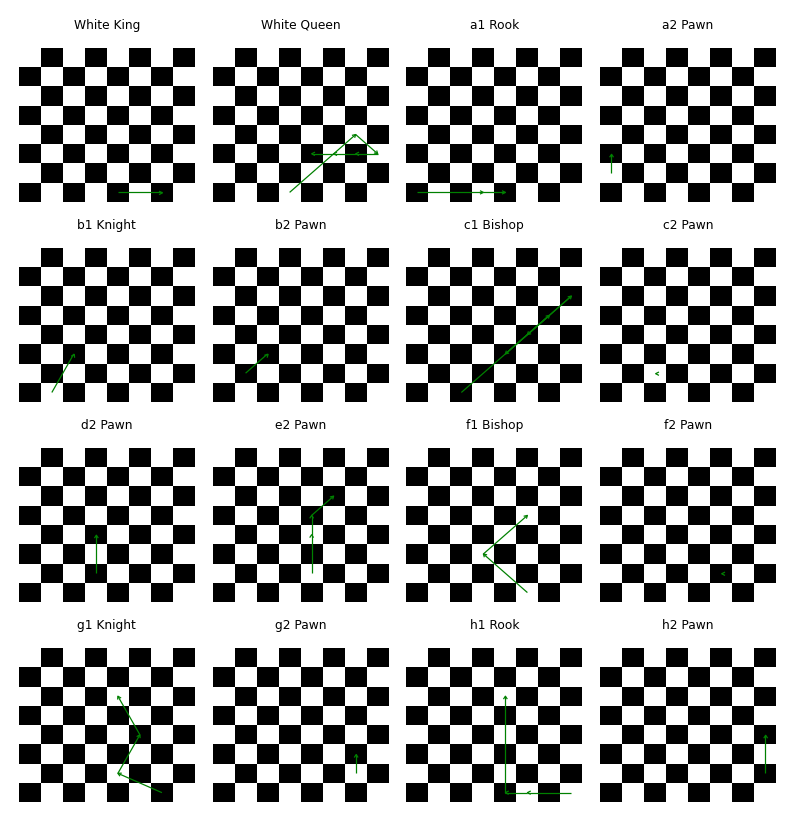

<ggplot: (-9223371905304297591)>

In [11]:
(ggplot(data = dfboard, mapping = aes(x = 'x', y = 'y', fill = 'color')) 
     + geom_tile() 
     + scale_fill_manual(guide = False, values =  ("black", "white"))
     + theme_void() 
     + geom_segment(data = white,#xo.loc[xo.Piece == 'White Queen'], 
                    mapping = aes(x = 'x_from', xend = 'x_to', y = 'y_from', yend = 'y_to'), color = 'green', 
                    #position = position_jitter(width = 0.3, height = 0.3),
                    lineend = 'round',
                    arrow = arrow(length=0.2),
                    inherit_aes= False)
    + facet_wrap('Piece')
    + theme(figure_size = (10, 10))
    )#.save()